##Clean Data

In [ ]:
%pip install stable_baselines3 alpha_vantage

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from stable_baselines3 import *

In [22]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SP500_10year_daily_TA.csv')
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
Index: 5614 entries, 1999-11-30 to 2022-03-22
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   5614 non-null   float64
 1   EMA     5614 non-null   float64
 2   SMA     5614 non-null   float64
 3   RSI     5614 non-null   float64
dtypes: float64(4)
memory usage: 219.3+ KB
None


,Close,EMA,SMA,RSI
1999-11-30,139.2812,92.2226,92.3476,56.5202
1999-12-01,140.4062,92.2868,92.5399,60.6184
1999-12-02,141.2500,92.3959,92.7302,63.4045
1999-12-03,143.8437,92.6512,92.9722,70.3486
1999-12-06,142.7812,92.8193,93.1346,64.9145
...,...,...,...,...
2022-03-16,435.6200,429.6451,428.4469,51.5283
2022-03-17,441.0700,430.5609,428.1712,54.7316
2022-03-18,444.5200,431.8299,428.6112,57.4101
2022-03-21,444.3900,432.9717,429.1857,57.3112


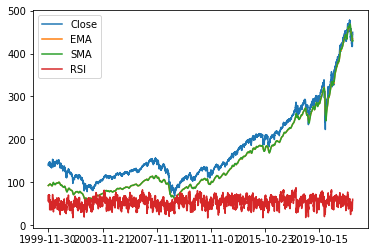

In [4]:
df.plot();

## Setting up DataFrame

In [5]:
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators

In [6]:
key = 'alphavantage api key'
ts = TimeSeries(key=key, output_format='pandas')
ti = TechIndicators(key=key, output_format='pandas')

In [7]:
def get_sma(symbol, interval='daily', time=20):
  return ti.get_sma(symbol=symbol, interval=interval, time_period=time, series_type='close')[0]

def get_ema(symbol, interval='daily', time=21):
  return ti.get_ema(symbol=symbol, interval=interval, time_period=time, series_type='close')[0]

def get_rsi(symbol, interval='daily'):
  return ti.get_rsi(symbol=symbol, interval=interval, time_period=14, series_type='close')[0]

In [8]:
def append_TA(dataframe, symbol='SPY'):
  dataframe['EMA'] = get_ema(symbol)
  dataframe['SMA'] = get_sma(symbol)
  dataframe['RSI'] = get_rsi(symbol)

  return dataframe

In [9]:
def drop_columns(dataframe, values=['Open', 'High', 'Low', 'Volume'], drop_na=True):
  dataframe = dataframe.drop(values, axis=1)
  if drop_na:
    dataframe = dataframe.dropna()

  return dataframe

Example on how to use

In [10]:
data, m = ts.get_daily(symbol='SPY', outputsize='full')
data = data.rename(columns={"1. open" : 'Open', "2. high" : "High", "3. low" : "Low", "4. close" : 'Close', "5. volume" : "Volume"})

In [11]:
data = append_TA(data)
data = drop_columns(data)
data

,Close,EMA,SMA,RSI
date,,,,
2022-03-22,449.5900,434.4825,430.2525,60.2597
2022-03-21,444.3900,432.9717,429.1857,57.3112
2022-03-18,444.5200,431.8299,428.6112,57.4101
2022-03-17,441.0700,430.5609,428.1712,54.7316
2022-03-16,435.6200,429.6451,428.4469,51.5283
...,...,...,...,...
1999-12-06,142.7812,92.8193,93.1346,64.9145
1999-12-03,143.8437,92.6512,92.9722,70.3486
1999-12-02,141.2500,92.3959,92.7302,63.4045


##Make Custom Environment

In [12]:
import gym
from gym import Env
from gym.spaces import *
from stable_baselines3 import DQN
from stable_baselines3.common.policies import *

## TODO

- test
- check padding for reaching end of window

In [13]:
class StockEnv(Env):
  ''' creates a new stock environment with the given dataframe
  - dataframe must already be pre-processed with date data structure as the index
    - i.e. using pd.to_datetime
    - dates must start at earliest time (so row 0 is the earliest time)
  - dataframe must contain price of the stock in a column named 'Close'

  - this environment allows us to buy, sell, or hold a stock every day with a discrete action space
    - 0 = hold

    - 1 = buy 1 share
    - 2 = buy 25% of your money to invest in shares
    - 3 = buy 50% of your money to invest
    - 4 = buy 75% of your money to invest
    - 5 = buy all of your money to invest

    - 6 = sell 1 share
    - 7 = sell 25% of your shares
    - 8 = sell 50% of your shares
    - 9 = sell 75% of your shares
    - 10 = sell all shares

  - hyperparameters also include start_index and window_size
    - start_index is the time that we start our data at
    - window_size is the period of time that we want to be looking at previously
      - i.e. 30 days behind 

  '''

  def __init__(self, df, investment=1000, start_index=0, end_index=None, window_size = 30):

    df.index = pd.to_datetime(df.index)
    self.df = df.sort_index()
    self.window_size = window_size
    self.end_index = len(self.df.index) if end_index == None else end_index # where we end the data

    self.money_left_to_invest = investment
    self.action_space = Discrete(11)

    spaces = self.setup_state()
    self.observation_space = gym.spaces.Dict(spaces)

    self.starting_index = start_index
    self.starting_investment = investment
    self.index = start_index # used for getting the prices
    self.current_time = self.index + self.window_size # the current day we are looking at

    prices = self._get_prices()
    self.shares = 0
    self.state = self.get_current_state()
    self.prev_money = 0

    self.money = []
    self.prev_render = []


  def setup_state(self):
    state = dict()
    shape = (self.window_size, )

    mins = np.min(self.df)
    maxes = np.max(self.df)
    
    for col in self.df.columns:
      state[col] = Box(low=mins[col], high=maxes[col], shape=shape, dtype=np.float32)

    state['money_left_to_invest'] = Box(low = 0, high=np.inf, shape=(1, ), dtype=np.float32)
    state['account_amount'] =  Box(low = 0, high=np.inf, shape=(1, ), dtype=np.float32)

    return state

  # gets the prices
  def _get_prices(self):
    # if we are near the end of the window, assume price stays constant
    if self.window_size + self.index > len(self.df.index):
      values = self.df.iloc[self.index:, :]['Close']
      return values.reindex(range(self.window_size), fill_value=np.mean(values)).tolist()

    values = self.df.iloc[self.index:self.window_size + self.index, :]['Close'].tolist()

    return values

  def get_total_money(self):
    return round(self.shares * self._get_today_price() + self.money_left_to_invest, 4)

  def _get_today_price(self):
      return self.df['Close'][self.current_time-1]

  def get_current_state(self):
    state = dict()
    state['account_amount'] =  self.shares * self._get_today_price()
    state['money_left_to_invest'] = self.money_left_to_invest

    if self.window_size + self.index > len(self.df.index):
      values = self.df.iloc[self.index:, :]
      values = values.reindex(range(self.window_size), fill_value=np.mean(values))

    else:
      values = self.df.iloc[self.index:self.window_size + self.index, :]

    for col in self.df.columns:
     state[col] = values[col].tolist()

    return state

  # sell n shares
  def sell_n_shares(self, n):
    n = int(n)
    if self.shares <= 0:
      return

    self.shares -= n
    self.money_left_to_invest += self._get_today_price() * n

  def buy_percent_shares(self, percent):
    shares_to_buy = (percent * self.money_left_to_invest) // self._get_today_price()
    cost = self._get_today_price() * shares_to_buy

    if cost <= self.money_left_to_invest:
      self.shares += shares_to_buy
      self.money_left_to_invest -= cost

  def step(self, action):

    # calculate state

    if action == 0: # hold
      pass

    elif action == 1: # buy
      cur_price = self._get_today_price()

      # if we have enough money left in our bank account to buy
      if self.money_left_to_invest >= cur_price:
        self.shares += 1
        self.money_left_to_invest -= cur_price

    elif action == 2: # invest 25% of your money left to invest
      self.buy_percent_shares(.25)

    elif action == 3: # invest 50% of your money left to invest
      self.buy_percent_shares(.5)
    
    elif action == 4: # invest 75% of your money left to invest
      self.buy_percent_shares(.75)

    elif action == 5: # buy as many shares as you can
      self.buy_percent_shares(1)

    elif action == 6:
      self.sell_n_shares(self.shares)

    elif action == 7: # sell 1 share
      self.sell_n_shares(1)

    elif action == 8: # sell 25% of shares
      self.sell_n_shares(.25 * self.shares)
    
    elif action == 9: # sell 50% of shares
      self.sell_n_shares(.5 * self.shares)

    elif action == 10: # sell 75% of shares
      self.sell_n_shares(.75 * self.shares)

    elif action == 11:
      self.sell_n_shares(self.shares)

    else:
      raise Exception("Invalid action")

    self.state = self.get_current_state()

    # calculate reward - how much money we made each timestep/trade
    reward = self.get_total_money() - self.prev_money
    self.prev_money = self.get_total_money()

    self.money.append(self.get_total_money())

    # calculate done
    done = self.current_time == self.end_index


    # advance to the next timestep
    self.index += 1 
    self.current_time = self.index + self.window_size

    # calculate info
    info = dict()
    info['Current Money'] = self.state['account_amount'] + self.money_left_to_invest
    info['Shares'] = self.shares
    info['Reward'] = reward
    info['Current Timestep'] = self.current_time

    return self.state, reward, done, info


  def render(self, mode='regular'):
    plt.clf()

    y = self.prev_render if mode == 'dummy' else self.money

    plt.plot(self.df.index[self.starting_index:len(y)], y)
    plt.show()
      

  def reset(self, mode=None):
    self.index = self.starting_index
    self.current_time = self.index + self.window_size

    prices = self._get_prices()
    self.shares = 0
    self.prev_money = 0
    self.money_left_to_invest = self.starting_investment

    self.prev_render = self.money
    self.money = []
    self.first_rendering = True

    self.state = self.get_current_state()


    return self.state

  def close(self):
        plt.close()

In [14]:
env = StockEnv(df)

env.observation_space.sample()

OrderedDict([('Close',
              array([ 92.42053, 244.90707, 326.5057 , 323.2421 , 213.61084, 432.1482 ,
                     203.22044, 279.9097 , 125.31443,  68.5146 , 250.40047, 205.0062 ,
                     425.9386 , 185.1877 , 134.35216, 350.5676 ,  78.20249, 135.50374,
                     179.63445, 230.1836 , 211.07776, 318.23383, 258.2395 ,  76.5447 ,
                     365.36563, 262.90857, 324.98422, 300.20087, 447.15195, 206.99977],
                    dtype=float32)),
             ('EMA',
              array([183.24149 , 247.79382 ,  79.68586 , 398.63834 ,  98.803375,
                     403.5745  , 415.4642  , 263.08862 , 362.85458 , 409.25146 ,
                     440.4277  , 146.2798  , 414.67896 , 408.965   , 434.59186 ,
                     237.78511 , 404.30127 , 318.44934 ,  81.262726, 447.95135 ,
                     142.23051 ,  85.28076 ,  80.28408 , 161.21857 , 321.2596  ,
                     449.15433 ,  88.85839 , 386.6043  , 126.95888 , 199.36429

Episode:0 Reward 31.200000000000273 


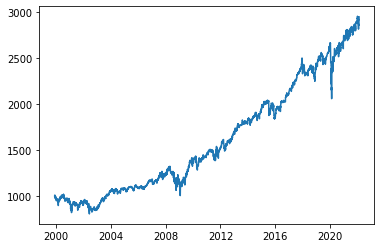

In [15]:
episodes = 1

for episode in range(episodes):
  state = env.reset()
  done = False
  score = 0

  while not done:

      action = env.action_space.sample()
      next_state, reward, done, info = env.step(action)
      
      score += reward

  print("Episode:{} Reward {} ".format(episode, reward))
  env.render()
  env.close()
                                   

## Rl Train

In [16]:
from stable_baselines3.common.vec_env import DummyVecEnv

results = []

env = StockEnv(data)
env = DummyVecEnv([lambda : env])

policy_kwargs = dict(net_arch=[2048, 2048])
model = DQN("MultiInputPolicy", env, verbose=1, gamma=.99, policy_kwargs=policy_kwargs)
model = model.learn(total_timesteps=500_000, log_interval=10) # does well with 10 million steps
model.save("SP500_dqn_model")

Using cuda device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10       |
|    fps              | 790      |
|    time_elapsed     | 70       |
|    total_timesteps  | 55850    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.91     |
|    n_updates        | 1462     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20       |
|    fps              | 377      |
|    time_elapsed     | 296      |
|    total_timesteps  | 111700   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.07     |
|    n_updates        | 15424    |
----------------------------------
----------------------------------
| rollout/            |          |
| 

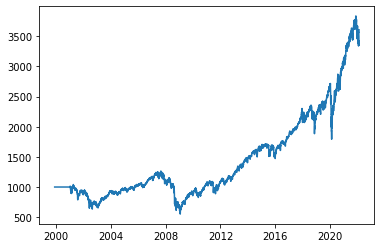

[{'Current Money': 3605.9999999999995, 'Shares': 8.0, 'Reward': 41.59999999999991, 'Current Timestep': 5615, 'terminal_observation': {'account_amount': 3596.72, 'money_left_to_invest': 9.27999999999993, 'Close': [450.94, 457.54, 449.32, 440.46, 439.02, 446.1, 446.6, 437.06, 434.23, 429.57, 421.95, 428.3, 437.75, 436.63, 429.98, 437.89, 435.71, 432.17, 419.43, 416.25, 427.41, 425.48, 420.07, 417.0, 426.17, 435.62, 441.07, 444.52, 444.39, 449.59], 'EMA': [449.8309, 450.4043, 450.1806, 449.1743, 448.1289, 447.8202, 447.5849, 446.5063, 445.2694, 443.7225, 441.6257, 440.295, 439.9417, 439.519, 438.5321, 438.3518, 437.9903, 437.3408, 435.5957, 433.7211, 433.0283, 432.2236, 431.0017, 429.6127, 429.181, 429.6451, 430.5609, 431.8299, 432.9717, 434.4825], 'SMA': [448.5008, 447.8921, 446.8105, 445.6106, 444.3296, 443.8117, 443.555, 443.0719, 442.885, 442.3731, 441.749, 441.4958, 441.8203, 441.5551, 440.5617, 439.811, 438.7323, 438.013, 436.554, 435.0082, 433.8353, 432.2372, 430.7792, 429.6098, 42

In [17]:
obs = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    
    if done:
      env.render(mode='dummy')
      print(info)
      results.append(info[0]['Current Money'])
      break

## Dict Observation Space

In [18]:
from stable_baselines3.ppo.ppo import PPO

env = StockEnv(data)
env = DummyVecEnv([lambda : env])



In [19]:
model = PPO("MultiInputPolicy", env, verbose=1)
model = model.learn(total_timesteps=500000, log_interval=10) # increase steps
model.save("SP500_ppo_model")

Using cuda device
-----------------------------------------
| time/                   |             |
|    fps                  | 269         |
|    iterations           | 10          |
|    time_elapsed         | 76          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.008119697 |
|    clip_fraction        | 0.0847      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.3        |
|    explained_variance   | -0.000352   |
|    learning_rate        | 0.0003      |
|    loss                 | 304         |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00632    |
|    value_loss           | 974         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 263         |
|    iterations           | 20          |
|    time_elapsed         | 155         |
|    total_times

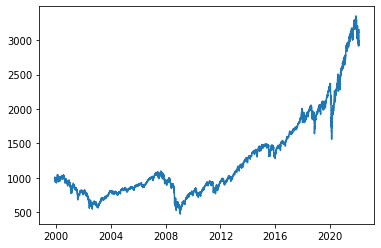

[{'Current Money': 3148.5362999999998, 'Shares': 7, 'Reward': 36.40000000000009, 'Current Timestep': 5615, 'terminal_observation': {'account_amount': 3147.1299999999997, 'money_left_to_invest': 1.4062999999999874, 'Close': [450.94, 457.54, 449.32, 440.46, 439.02, 446.1, 446.6, 437.06, 434.23, 429.57, 421.95, 428.3, 437.75, 436.63, 429.98, 437.89, 435.71, 432.17, 419.43, 416.25, 427.41, 425.48, 420.07, 417.0, 426.17, 435.62, 441.07, 444.52, 444.39, 449.59], 'EMA': [449.8309, 450.4043, 450.1806, 449.1743, 448.1289, 447.8202, 447.5849, 446.5063, 445.2694, 443.7225, 441.6257, 440.295, 439.9417, 439.519, 438.5321, 438.3518, 437.9903, 437.3408, 435.5957, 433.7211, 433.0283, 432.2236, 431.0017, 429.6127, 429.181, 429.6451, 430.5609, 431.8299, 432.9717, 434.4825], 'SMA': [448.5008, 447.8921, 446.8105, 445.6106, 444.3296, 443.8117, 443.555, 443.0719, 442.885, 442.3731, 441.749, 441.4958, 441.8203, 441.5551, 440.5617, 439.811, 438.7323, 438.013, 436.554, 435.0082, 433.8353, 432.2372, 430.7792, 4

In [20]:
obs = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)

    if done:
      env.render(mode='dummy')
      print(info)
      results.append(info[0]['Current Money'])
      break

In [21]:
results

[3605.9999999999995, 3148.5362999999998]